In [45]:
# Facebook Prophet
# 超参数
VAULE_X = 'date'
VAULE_Y = 'amount'

import pandas as pd
from pandas import to_datetime
import numpy as np
from matplotlib import pyplot

from prophet import Prophet
# print version number
print('Prophet %s' % prophet.__version__)

Prophet 1.1.5


(151, 13)
       date  order_cnt       amount text_day text_night  high  low wc_day  \
0  2023-1-1     893054  264154248.5        阴          阴     8    5    <3级   
1  2023-1-2    1042898  313342671.6        阴         多云     9    0    <3级   
2  2023-1-3    1174827  366979346.9       多云         多云     9    0    <3级   
3  2023-1-4     863885  266000333.6       多云         多云    12    3   3~4级   
4  2023-1-5     885530  276122514.9       多云         多云    13    2    <3级   

  wd_day wc_night wd_night week holidays  
0     东风      <3级      东北风  星期日       元旦  
1     北风      <3级       东风  星期一       元旦  
2    东南风      <3级       东风  星期二       平时  
3    东南风      <3级       东风  星期三       平时  
4     南风      <3级       西风  星期四       平时  


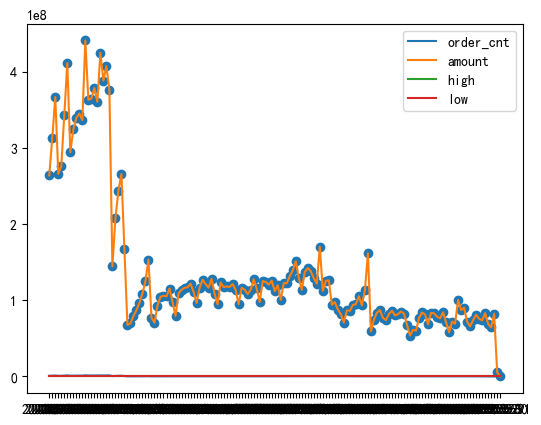

In [46]:

# 读取excel文件并获取指定列
#df = pd.read_csv('Data\store_6922.csv', usecols=['dt', 'amt', 'discount_amount', 'pay_amount', 'num', 'discount', 'discount_percent', 'workdays', 'holidays', 'weekdays', 'text_day', 'text_night', 'high', 'low', 'high_low', 'wc_day'], encoding='GBK')
df = pd.read_csv('Data\结果1_全站按日数据_最近2年数据.csv', usecols=['date', 'amount', 'order_cnt', 'text_day', 'text_night', 'high', 'low', 'wc_day', 'wd_day', 'wc_night', 'wd_night', 'week', 'holidays'], encoding='GBK')
print(df.shape)
print(df.head())
df.plot()

# 设置字体，确保能正确显示汉字
pyplot.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 绘制散点图
pyplot.scatter(df[VAULE_X], df[VAULE_Y])
pyplot.show()

06:30:21 - cmdstanpy - INFO - Chain [1] start processing
06:30:21 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2023-06-01  6.646802e+07  1.080261e+07  1.239832e+08
1 2023-06-02  8.199100e+07  2.596967e+07  1.391047e+08
2 2023-06-03  6.401466e+07  1.202017e+07  1.218652e+08
3 2023-06-04  4.080064e+07 -2.071083e+07  9.422927e+07
4 2023-06-05  6.427351e+07  9.116120e+06  1.242306e+08


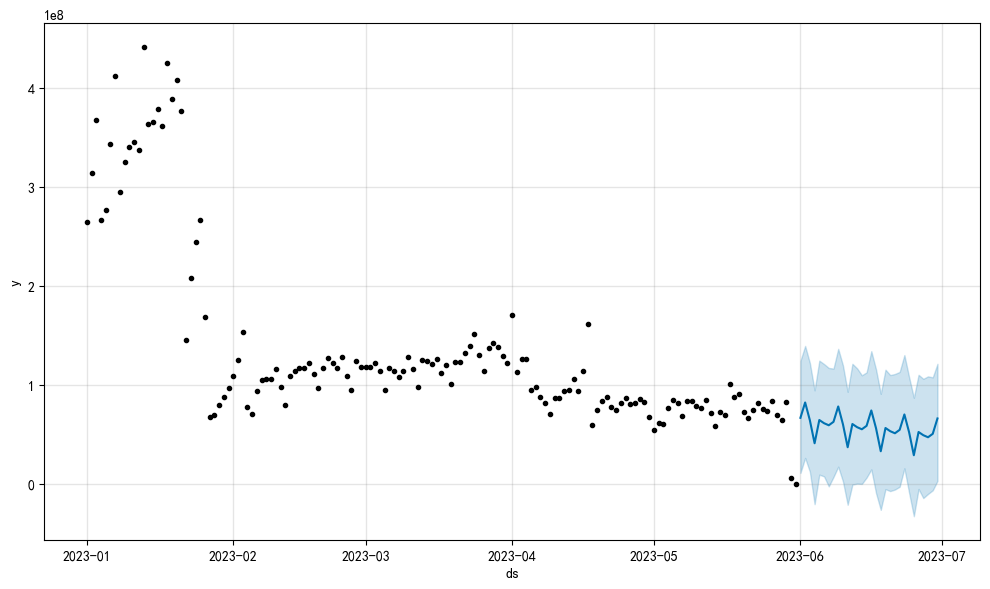

In [47]:

# 第一步：构建输入DataFrame 
# 第一列必须被命名为“ds”并包含日期信息； 第二列必须被命名为“y”并包含观测结果。
df_prophet = df[['date', 'amount']].copy()
df_prophet.rename(columns={'date':'ds', 'amount':'y'}, inplace=True) 

# 第二步：模型拟合
model = Prophet()
model.add_country_holidays(country_name="CN")
model.fit(df_prophet)

# 第三步：构建预测DataFrame：future, 这个future是预测的日期，只有2023-06-01至30日的数据
future = list()
for i in range(1, 31):
    dateToPredict = '2023-06-%02d' % i
    future.append([dateToPredict])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# 第四步：模型预测
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# 第五步：绘制图形
model.plot(forecast)
pyplot.show()

06:30:21 - cmdstanpy - INFO - Chain [1] start processing
06:30:21 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2023-05-01  8.995308e+07  2.712396e+07  1.517400e+08
1 2023-05-02  9.078905e+07  3.196360e+07  1.580808e+08
2 2023-05-03  8.690798e+07  2.495689e+07  1.450648e+08
3 2023-05-04  8.821759e+07  3.078405e+07  1.544225e+08
4 2023-05-05  1.060858e+08  4.854594e+07  1.706603e+08


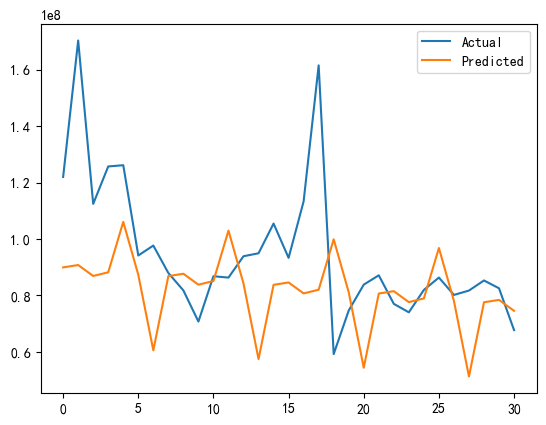

In [48]:
# 第六步：评估效果
## 第6.1步：留出检验集（扔掉后31行）
df_prophet_train = df_prophet.drop(df_prophet.index[-31:])

## 第6.2步：模型拟合（用中国的节假日）
model = Prophet()
model.add_country_holidays(country_name="CN")
model.fit(df_prophet_train)

## 第6.3步：构建预测集
df_prophet_future = list()
for i in range(1, 32):
    dateToPredict = '2023-05-%02d' % i
    df_prophet_future.append([dateToPredict])
df_prophet_future = pd.DataFrame(df_prophet_future)
df_prophet_future.columns = ['ds']
df_prophet_future['ds']= to_datetime(df_prophet_future['ds'])

## 第6.4步：模型预测
forecast = model.predict(df_prophet_future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

## 第6.5步：比较检验集和预测集两者差异
y_true = df_prophet_train['y'][-31:].values
y_pred = forecast['yhat'].values
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()